In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Obtenemos la lista de GPUs disponibles

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs disponibles:")
    for gpu in gpus:
        print(" -", gpu)
else:
    print("No se detectaron GPUs. Se usará la CPU.")


No se detectaron GPUs. Se usará la CPU.


2025-05-05 20:34:47.759391: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-05 20:34:47.759438: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: bf9142dd9ae1
2025-05-05 20:34:47.759447: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: bf9142dd9ae1
2025-05-05 20:34:47.759620: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.120.0
2025-05-05 20:34:47.759660: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.120.0
2025-05-05 20:34:47.759668: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.120.0


In [4]:

!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [1]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

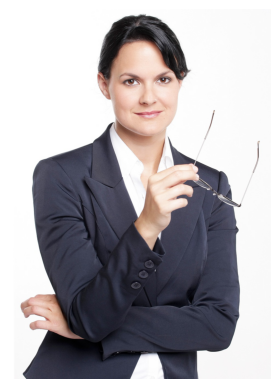

In [2]:
!wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

import cv2
import matplotlib.pyplot as plt

img = cv2.imread("image.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para que los colores sean correctos en matplotlib

# Mostrar la imagen con matplotlib
plt.imshow(img)
plt.axis("off")  # Ocultar los ejes
plt.show()

I0000 00:00:1746563133.889244     763 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1746563133.889580     763 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1746563133.894953     933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746563133.906089     941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


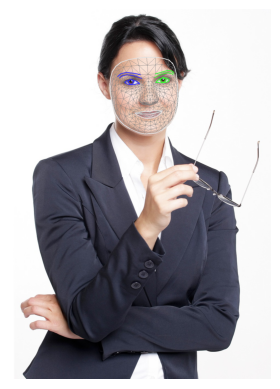

deteccion en 0.010081291198730469


In [3]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import time

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task', delegate=python.BaseOptions.Delegate.CPU)
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

inicio_tiempo = time.time()
# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)
elapsed_tiempo = time.time() - inicio_tiempo

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(annotated_image)
plt.axis("off")  # Ocultar los ejes
plt.show()
print(f"deteccion en {elapsed_tiempo}")
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


In [18]:
print(dir(detection_result))
for attr in dir(detection_result):
    if not attr.startswith("_"):
        try:
            attr_value = getattr(detection_result, attr)
            print(f"{attr} -> {attr_value}")
            print("----"*10)
        except Exception as e:
            print(f"{attr} -> Error al acceder: {e}")


['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'face_blendshapes', 'face_landmarks', 'facial_transformation_matrixes']
face_blendshapes -> [[Category(index=0, score=2.72534475698194e-06, display_name='', category_name='_neutral'), Category(index=1, score=0.1256560981273651, display_name='', category_name='browDownLeft'), Category(index=2, score=0.10741740465164185, display_name='', category_name='browDownRight'), Category(index=3, score=0.00015090849774423987, display_name='', category_name='browInnerUp'), Category(index=4, score=0.05803155526518822, display_name='', category_name='browOuterUpL

In [4]:
len(detection_result.face_landmarks[0])

478

In [5]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.92209911e-01, -6.04962148e-02,  1.08903199e-01,
         1.18749952e+00],
       [ 9.10462737e-02,  9.48806942e-01, -3.02450448e-01,
         2.23723984e+01],
       [-8.50309655e-02,  3.10009331e-01,  9.46923494e-01,
        -6.80146637e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


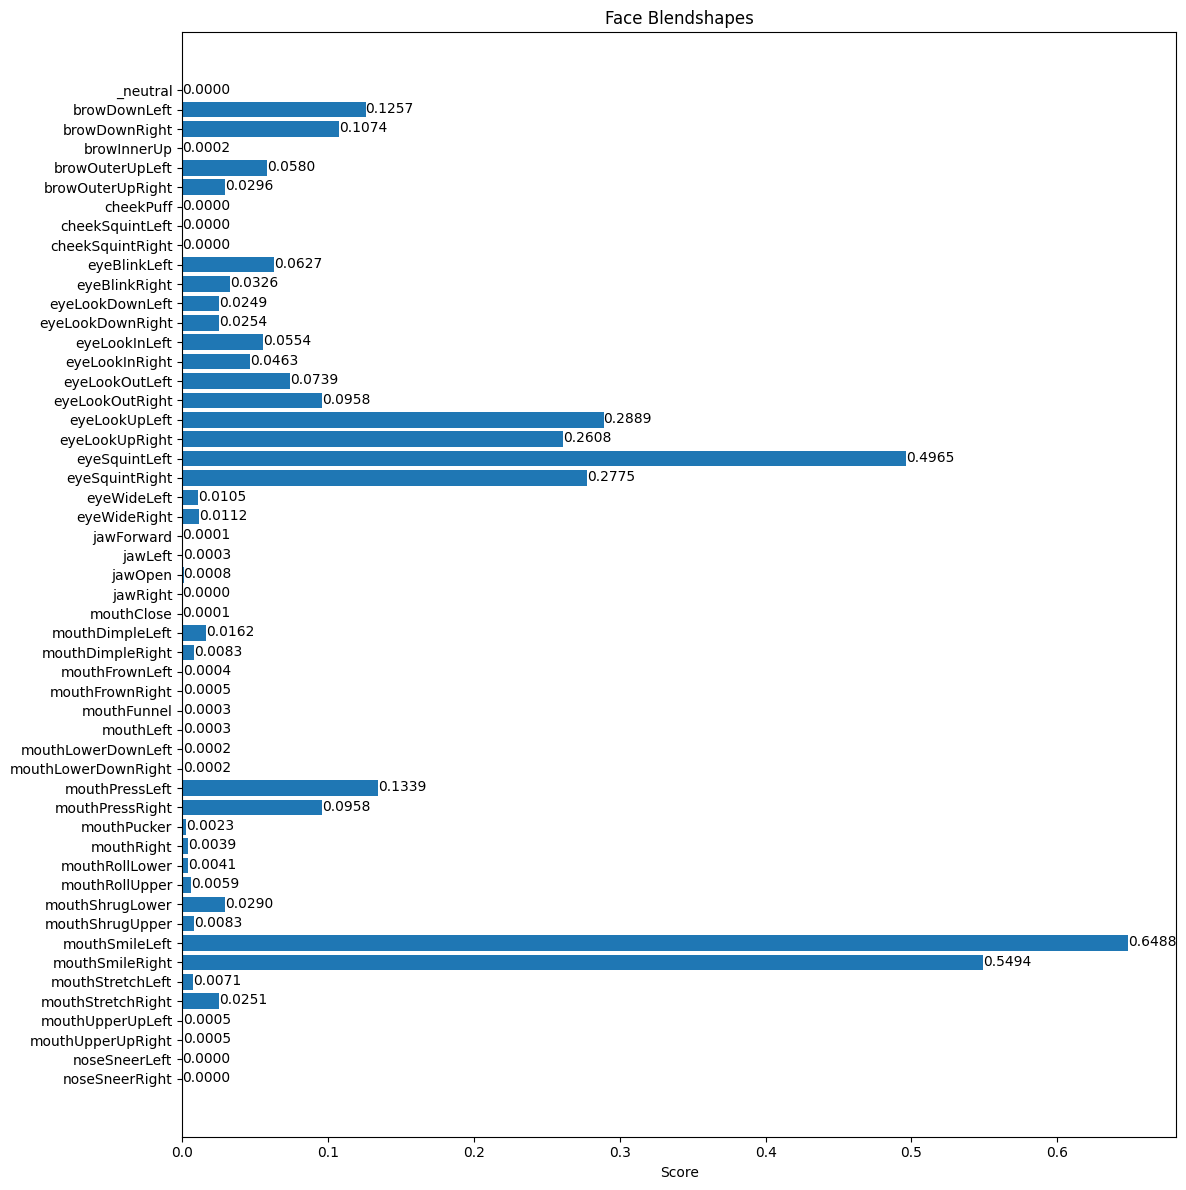

In [6]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [14]:
print(len(detection_result.facial_transformation_matrixes[0]))
print(detection_result.facial_transformation_matrixes)

4
[array([[ 9.92209911e-01, -6.04962148e-02,  1.08903199e-01,
         1.18749952e+00],
       [ 9.10462737e-02,  9.48806942e-01, -3.02450448e-01,
         2.23723984e+01],
       [-8.50309655e-02,  3.10009331e-01,  9.46923494e-01,
        -6.80146637e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


In [5]:
!pip install -q mediapipe --root-

In [11]:
#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image